# <span style="color:yellow">New Classes and Some Functions</span>

In [1]:
from TMclass import *
import datetime
fromiso = datetime.datetime.fromisoformat
tdelta = datetime.timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree


def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += datetime.timedelta(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + datetime.timedelta(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += datetime.timedelta(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(datetime.datetime.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



In [22]:
def syn_crop(rsyn_list,crpk_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    crpk = crpk_list[0]
    ic = crpk_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    if type(ndata) is int:
        kw = crpk.cropping(ti,ndata=ndata,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
        kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=ndata,level='raw.crop'); PHI.saving(ic,**kw)
        print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

    else:
        for i,n in enumerate(ndata):
            if len(crpk_list)>2:
                crpk = crpk_list[2*i]
                ic = crpk_list[2*i+1]
            kw = crpk.cropping(ti + tdelta(minutes=2),ndata=n,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
            kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=n,level='raw.crop'); PHI.saving(ic,**kw)
            ti = kw['end'] + tdelta(minutes=2)
            print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

def syn(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
#     kw = rsyn.cropping(ti,ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(ir,**kw)
#     kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(ir,**kw)
#     print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    kw = rsyn.compressing(ti, nbits = 6, ndata = 12,level='raw.pack'); PHI.saving(ir,**kw)
    print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    kw = fl.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = ndata,level='raw.pack'); PHI.saving(il,**kw)
    print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
def syn_flush(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    if type(ndata) is int:
        kw = fl.compressing(ti, nbits = 6, ndata = ndata,level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    else:
        kw = fl.compressing(ti, nbits = 6, ndata = ndata[0],level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
        fl = fl_list[2]
        il = fl_list[3]
        kw = fl.compressing(ti, nbits = 6, ndata = ndata[1],level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

def syn_flush_crop(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    crpk = fl_list[2]
    ic = fl_list[3]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    kw = fl.compressing(ti, nbits = 6, ndata = ndata[0],level='raw.pack'); PHI.saving(il,**kw)
    print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    if type(ndata[1]) is int:
        kw = crpk.cropping(ti,ndata=ndata[1],crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
        kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=ndata[1],level='raw.crop'); PHI.saving(ic,**kw)
    else:
        for n in ndata[1]:
            kw = crpk.cropping(ti + tdelta(minutes=2),ndata=n,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
            kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=n,level='raw.crop'); PHI.saving(ic,**kw)
            ti = kw['end'] + tdelta(minutes=2)
    print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])


# <span style="color:blue">R_FULL_LRES_HCAD_Full-Disk-Helioseismology</span>


In [3]:
hcrop = 640
rcrop = 1024

In [54]:
t0 = fromiso('2022-01-20T00:00:00')
t1 = fromiso('2022-01-21T23:56:00')
PHI = PHI_MEMORY(t0)
phi = PHI_MEMORY(t0)

hsm_1 = PHI_MODE('FDT')
kw = hsm_1.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(1,**kw)
print(f'{hsm_1.raw.n_datasets} datasets acquired')
# t0 = hsm_1.raw.end

# PHI.copy_partition(1,t0)
# PHI.format_partition(1,PHI.part1.history['end'][-1])


t0 = fromiso('2022-01-22T00:10:00')
t1 = fromiso('2022-01-23T23:56:00')
hsm_2 = PHI_MODE('FDT')
kw = hsm_2.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(2,**kw)
print(f'{hsm_2.raw.n_datasets} datasets acquired')

t0 = fromiso('2022-01-24T00:10:00')

kw = hsm_1.cropping(t0 + tdelta(minutes=5),ndata=720,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=720,level='raw.crop'); PHI.saving(1,**kw)

# kw = hsm_1.cropping(kw['end'] + tdelta(minutes=5),ndata=80*5,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
# kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=80*5,level='raw.crop'); PHI.saving(1,**kw)
kw = hsm_1.cropping(kw['end'] + tdelta(minutes=5),ndata=180,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=180,level='raw.crop'); PHI.saving(1,**kw)

print(f'end of packing and cropping of {hsm_1.raw.pack.n_datasets}/{hsm_1.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

t0 = fromiso('2022-01-24T20:45:00')
# kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
# kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 370,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 350,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 20,level='raw.pack'); PHI.saving(1,**kw)

print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run*2} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])


t0 = fromiso('2022-01-25T00:15:00')

# kw = hsm_1.cropping(t0 + tdelta(minutes=5),ndata=720,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
# kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=720,level='raw.crop'); PHI.saving(1,**kw)
kw = hsm_1.cropping(t0 + tdelta(minutes=5),ndata=538,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=538,level='raw.crop'); PHI.saving(1,**kw)

# kw = hsm_1.cropping(kw['end'] + tdelta(minutes=5),ndata=80*4-2,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
# kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=80*4-2,level='raw.crop'); PHI.saving(1,**kw)
kw = hsm_1.cropping(kw['end'] + tdelta(minutes=5),ndata=362,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=362,level='raw.crop'); PHI.saving(1,**kw)

print(f'end of packing and cropping of {hsm_1.raw.pack.n_datasets}/{hsm_1.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

t0 = fromiso('2022-01-25T20:45:00')
# kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
# kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 370,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 328,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 40,level='raw.pack'); PHI.saving(1,**kw)

print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run*2} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])


t0 = fromiso('2022-01-26T00:15:00')

kw = hsm_1.cropping(t0 + tdelta(minutes=5),ndata=358,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=358,level='raw.crop'); PHI.saving(1,**kw)
kw = hsm_1.cropping(t0 + tdelta(minutes=5),ndata=542,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=542,level='raw.crop'); PHI.saving(1,**kw)

print(f'end of packing and cropping of {hsm_1.raw.pack.n_datasets}/{hsm_1.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

# kw = hsm_2.cropping(kw['end'] + tdelta(minutes=5),ndata=80*5,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
# kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=80*5,level='raw.crop'); PHI.saving(2,**kw)
# kw = hsm_2.cropping(kw['end'] + tdelta(minutes=5),ndata=224,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
# kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=224,level='raw.crop'); PHI.saving(2,**kw)

# print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

t0 = fromiso('2022-01-26T20:45:00')
# kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 328,level='raw.pack'); PHI.saving(1,**kw)
# kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
# kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 260,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 370,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(t0+tdelta(minutes=5), nbits = 6, ndata = 310,level='raw.pack'); PHI.saving(1,**kw)
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 60,level='raw.pack'); PHI.saving(1,**kw)

print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])


2876 datasets acquired
2866 datasets acquired
end of packing and cropping of 900/2876 datasets: 2022-01-24T14:03:56
end of flushing 37.0 MB (40 datasets, 740/2876): 2022-01-25T00:12:45
end of packing and cropping of 1800/2876 datasets: 2022-01-25T14:08:56
end of flushing 74.0 MB (80 datasets, 1478/2876): 2022-01-26T00:12:15
end of packing and cropping of 2700/2876 datasets: 2022-01-26T08:35:10
end of flushing 111.0 MB (60 datasets, 2218/2876): 2022-01-26T22:31:22


# <span style="color:blue">Raw Synoptic</span>

In [55]:
rsyn = PHI_MODE('FDT')
#################2022-01-27##############################

t0 = fromiso('2022-01-27T01:30:00')
t1 = fromiso('2022-01-28T01:30:00')

cad = 4*60
N = int((t1 - t0).total_seconds() / (60*cad))

# ti = t0
deltat = (t1 - t0)/N

t_arr = [t0 + deltat*i for i in range(N)]
func_arr = [syn_crop,syn_crop,syn_crop,syn_crop,syn_crop,syn_crop]
ndata_arr = [[128,30],160,160,160,160,6]
obs_arr = [[hsm_1,1,hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[rsyn,1]]

kw = hsm_1.cropping(t0 - tdelta(minutes=75),ndata=48,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(kw['end'] + tdelta(minutes=5),ndata=48,level='raw.crop'); PHI.saving(1,**kw)

print(f'end of packing and cropping of {hsm_1.raw.pack.n_datasets}/{hsm_1.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])


for ti,func,ndata,obs in zip(t_arr,func_arr,ndata_arr,obs_arr):
    if obs[0] == rsyn:
        func([rsyn,1],obs,ti,ndata,rcrop,rcrop)
    else:
        func([rsyn,1],obs,ti,ndata,rcrop,hcrop)

kw = hsm_2.cropping(ti + tdelta(minutes=30),ndata=40,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=40,level='raw.crop'); PHI.saving(2,**kw)
kw = hsm_2.cropping(kw['end'] + tdelta(minutes=5),ndata=40,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=40,level='raw.crop'); PHI.saving(2,**kw)

print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

#################2022-01-28##############################

t0 = fromiso('2022-01-28T01:30:00')
t1 = fromiso('2022-01-29T01:30:00')

cad = 4*60
N = int((t1 - t0).total_seconds() / (60*cad))

# ti = t0
deltat = (t1 - t0)/N

t_arr = [t0 + deltat*i for i in range(N)]
func_arr = [syn_flush,syn_crop,syn_crop,syn_crop,syn_crop,syn_crop]
ndata_arr = [[448,280],160,160,160,160,6]
obs_arr = [[hsm_1,1,hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[rsyn,1]]

kw = rsyn.compressing(t0-tdelta(minutes=70), nbits = 6, ndata = 6,level='raw.pack'); PHI.saving(1,**kw)
print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
kw = hsm_1.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 210,level='raw.pack'); PHI.saving(1,**kw)
print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])


for ti,func,ndata,obs in zip(t_arr,func_arr,ndata_arr,obs_arr):
    if obs[0] == rsyn:
        func([rsyn,1],obs,ti,ndata,rcrop,rcrop)
    else:
        func([rsyn,1],obs,ti,ndata,rcrop,hcrop)

kw = hsm_2.cropping(ti + tdelta(minutes=30),ndata=38,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=38,level='raw.crop'); PHI.saving(2,**kw)
kw = hsm_2.cropping(kw['end'] + tdelta(minutes=5),ndata=40,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=40,level='raw.crop'); PHI.saving(2,**kw)

print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

#################2022-01-29##############################

t0 = fromiso('2022-01-29T01:30:00')
t1 = fromiso('2022-01-30T01:30:00')

cad = 4*60
N = int((t1 - t0).total_seconds() / (60*cad))

# ti = t0
deltat = (t1 - t0)/N

t_arr = [t0 + deltat*i for i in range(N)]
func_arr = [syn_flush,syn_crop,syn_crop,syn_crop,syn_crop,syn_crop]
ndata_arr = [220+230+280,160,160,160,160,6]
obs_arr = [[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[rsyn,2]]

kw = rsyn.compressing(t0-tdelta(minutes=70), nbits = 6, ndata = 6,level='raw.pack'); PHI.saving(1,**kw)
print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
kw = hsm_2.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 210,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

for ti,func,ndata,obs in zip(t_arr,func_arr,ndata_arr,obs_arr):
    if obs[0] == rsyn:
        func([rsyn,2],obs,ti,ndata,rcrop,rcrop)
    else:
        func([rsyn,2],obs,ti,ndata,rcrop,hcrop)

kw = hsm_2.cropping(ti + tdelta(minutes=30),ndata=40,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=40,level='raw.crop'); PHI.saving(2,**kw)
kw = hsm_2.cropping(kw['end'] + tdelta(minutes=5),ndata=40,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=40,level='raw.crop'); PHI.saving(2,**kw)

print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

#################2022-01-30##############################

t0 = fromiso('2022-01-30T01:30:00')
t1 = fromiso('2022-01-31T01:30:00')

cad = 4*60
N = int((t1 - t0).total_seconds() / (60*cad))

# ti = t0
deltat = (t1 - t0)/N

kw = rsyn.compressing(t0-tdelta(minutes=70), nbits = 6, ndata = 6,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
kw = hsm_2.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 208,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

t_arr = [t0 + deltat*i for i in range(N)]
func_arr = [syn_flush,syn_crop,syn_crop,syn_crop,syn_crop,syn_crop]
ndata_arr = [450+270,160,160,160,160,6]
obs_arr = [[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[hsm_2,2],[rsyn,2]]

for ti,func,ndata,obs in zip(t_arr,func_arr,ndata_arr,obs_arr):
    if obs[0] == rsyn:
        func([rsyn,2],obs,ti,ndata,rcrop,rcrop)
    else:
        func([rsyn,2],obs,ti,ndata,rcrop,hcrop)

kw = hsm_2.cropping(ti + tdelta(minutes=30),ndata=38,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=38,level='raw.crop'); PHI.saving(2,**kw)

print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

#################2022-01-31##############################

t0 = fromiso('2022-01-31T01:30:00')
t1 = fromiso('2022-02-01T01:30:00')

cad = 4*60
N = int((t1 - t0).total_seconds() / (60*cad))

# ti = t0
deltat = (t1 - t0)/N

t_arr = [t0 + deltat*i for i in range(N)]

kw = rsyn.compressing(t0-tdelta(minutes=70), nbits = 6, ndata = 6,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
kw = hsm_2.compressing(kw['end']+tdelta(minutes=10), nbits = 6, ndata = 368+350,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])



end of packing and cropping of 2748/2876 datasets: 2022-01-27T01:03:24
end of packing and cropping of 2876/2876 datasets: 2022-01-27T03:34:45
end of packing and cropping of 30/2866 datasets: 2022-01-27T04:07:53
end of packing and cropping of 190/2866 datasets: 2022-01-27T08:01:42
end of packing and cropping of 350/2866 datasets: 2022-01-27T12:01:42
end of packing and cropping of 510/2866 datasets: 2022-01-27T16:01:42
end of packing and cropping of 670/2866 datasets: 2022-01-27T20:01:42
end of packing and cropping of 6/6 datasets: 2022-01-27T21:45:35
end of packing and cropping of 750/2866 datasets: 2022-01-27T23:27:21
end of flushing 113.0 MB (6 datasets, 6/6): 2022-01-28T00:35:06
end of flushing 389.0 MB (210 datasets, 2428/2876): 2022-01-28T01:36:58
end of flushing 830.0 MB (448 datasets, 2876/2876): 2022-01-28T03:25:38
end of flushing 519.0 MB (280 datasets, 280/2866): 2022-01-28T02:44:08
end of packing and cropping of 910/2866 datasets: 2022-01-28T08:01:42
end of packing and croppi

234.784 GB in partition 1 before partition
233.984 GB in partition 2


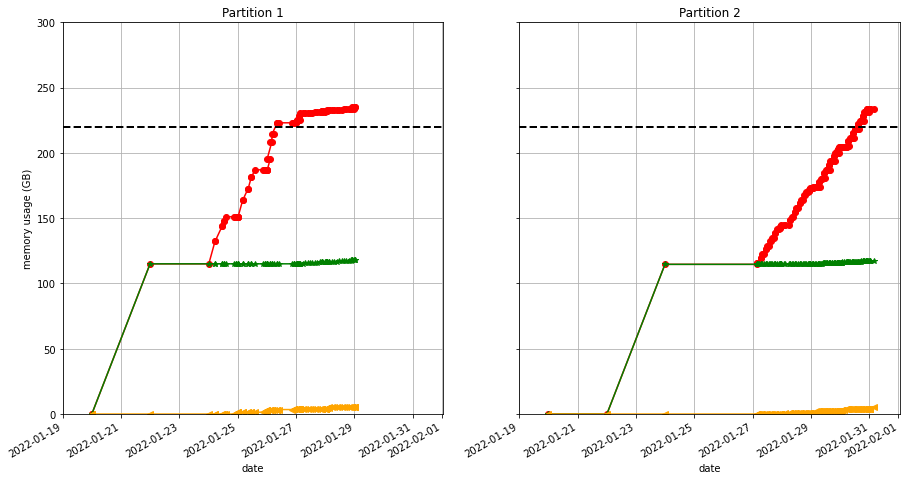

In [59]:
plot_tot(PHI,ylim=(0,300),xlim=(datetime.datetime(2022,1,19,0,0,0),datetime.datetime(2022,2,1,1,0,0)),time_ord=True)
# PHI.save('/home/calchetti/Desktop/ltp06-prova_V0.csv')
print(PHI.part1.occu/1e3,'GB in partition 1 before partition')
print(PHI.part2.occu/1e3,'GB in partition 2')


In [29]:
hsm_1.raw.data_tot+hsm_1.raw.crop.data_tot+hsm_1.raw.pack.data_tot
# hsm_2.raw.data_tot+(hsm_2.raw.crop.data_tot+hsm_2.raw.pack.data_tot*2866/hsm_2.raw.pack.n_datasets)
# (rsyn.raw.data_tot+rsyn.raw.crop.data_tot+rsyn.raw.pack.data_tot)/8

230080

In [49]:
temp = 1024*1024*24*6/8e6
print(temp)
print(roundup(temp,8))
(216+112+64)*12

18.874368
24


4704

In [80]:
i=1
#################2022-01-27##############################

# t0 = datetime.datetime.fromisoformat('2022-02-05T00:00:00')
t0 = fromiso('2022-01-27T00:30:00')
t1 = fromiso('2022-01-28T00:30:00')

cad = 2*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(1,**kw)

# ndata = np.ones(23, dtype='int')*50; ndata[6] = 10; ndata[21] = 18
# ndata = np.ones(N, dtype='int')*40; ndata[3] = 16; ndata[4] = 10; ndata[18] = 20; ndata[19] = 20; ndata[14] = 12; ndata[22] = 11; 
ndata = np.ones(N, dtype='int')*60; ndata[0] = 86; ndata[3] = 80; ndata[4] = 85; ndata[19] = 20; ndata[14] = 12; ndata[22] = 11; 
ndata = [86,60,60,80,85,]
for n in range(N):
    
    if (ti.hour == 14 or ti.hour == 22):
        # kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=39,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=2),ndata=ndata[n],crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        # kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=39,level='raw.crop'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=2),ndata=ndata[n],level='raw.crop'); PHI.saving(1,**kw)
        # print(f'end of packing and cropping of {hsm_2.raw.pack.this_run + rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        print(f'end of packing and cropping of {rsyn.raw.pack.n_datasets}/{rsyn.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour < 23:
        kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=ndata[n],crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
        kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=ndata[n],level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 23:
        # kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=6,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        # kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=6,level='raw.crop'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(1,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        kw = rsyn.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = 24,level='raw.pack'); PHI.saving(1,**kw)
        print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    ti = ti + deltat
        
#################2022-01-28##############################

t0 = fromiso('2022-01-28T01:30:00')
t1 = fromiso('2022-01-28T04:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(1,**kw)

ndata = np.ones(N, dtype='int')*140; ndata[-1] = 255
for n in range(N):

    kw = hsm_1.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = ndata[n],level='raw.pack'); PHI.saving(1,**kw)
    print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    ti = ti + deltat

t0 = fromiso('2022-01-28T05:30:00')
t1 = fromiso('2022-01-29T00:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
# rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(1,**kw)

ndata = np.ones(N, dtype='int')*40; ndata[13] = 14; ndata[14] = 14 # 0 is ti.hour==5
for n in range(N):
    
    if ti.hour == 12:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=3,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=8,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=3,level='raw.crop'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=8,level='raw.crop'); PHI.saving(1,**kw)

        print(f'end of packing and cropping of {rsyn.raw.pack.n_datasets}/{rsyn.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour < 22:
        kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=ndata[n],crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
        kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=ndata[n],level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 22:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=10,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=10,level='raw.crop'); PHI.saving(1,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 23:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(1,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        kw = rsyn.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = 22,level='raw.pack'); PHI.saving(1,**kw)
        print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
    ti = ti + deltat


#################2022-01-29##############################

t0 = fromiso('2022-01-29T01:30:00')
t1 = fromiso('2022-01-29T04:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(2,**kw)

ndata = np.ones(N, dtype='int')*140; ndata[-1] = 275; ndata[0] = 131
for n in range(N):

    kw = hsm_1.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = ndata[n],level='raw.pack'); PHI.saving(1,**kw)
    print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    ti = ti + deltat

t0 = fromiso('2022-01-29T05:30:00')
t1 = fromiso('2022-01-30T00:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
# rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(2,**kw)

ndata = np.ones(N, dtype='int')*40; ndata[11] = 38; ndata[13] = 15; ndata[14] = 15 # 0 is ti.hour==5
for n in range(N):
    
    if ti.hour == 12:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=3,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=8,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=3,level='raw.crop'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=8,level='raw.crop'); PHI.saving(2,**kw)

        print(f'end of packing and cropping of {rsyn.raw.pack.n_datasets}/{rsyn.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour < 22:
        kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=ndata[n],crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
        kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=ndata[n],level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 22:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=10,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=10,level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 23:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        kw = rsyn.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = 22,level='raw.pack'); PHI.saving(2,**kw)
        print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
    ti = ti + deltat

#################2022-01-30##############################

t0 = fromiso('2022-01-30T01:30:00')
t1 = fromiso('2022-01-30T04:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(2,**kw)

ndata = np.ones(N, dtype='int')*140; ndata[1] = 95; ndata[-1] = 270
for n in range(N):
    if ti.hour == 1:
        kw = hsm_1.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = ndata[n],level='raw.pack'); PHI.saving(1,**kw)
        print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 2:
        kw = hsm_1.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = ndata[n],level='raw.pack'); PHI.saving(1,**kw)
        print(f'end of flushing {round(hsm_1.compr.pack.data,0)} MB ({hsm_1.compr.pack.this_run} datasets, {hsm_1.compr.pack.n_datasets}/{hsm_1.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
        kw = hsm_2.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = 45,level='raw.pack'); PHI.saving(2,**kw)
        print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    else:
        kw = hsm_2.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = ndata[n],level='raw.pack'); PHI.saving(2,**kw)
        print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

    ti = ti + deltat

t0 = fromiso('2022-01-30T05:30:00')
t1 = fromiso('2022-01-31T00:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
# rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(2,**kw)

ndata = np.ones(N, dtype='int')*40; ndata[13] = 15; ndata[14] = 15 # 0 is ti.hour==5
for n in range(N):
    
    if ti.hour == 12:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=3,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=8,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=3,level='raw.crop'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=8,level='raw.crop'); PHI.saving(2,**kw)

        print(f'end of packing and cropping of {rsyn.raw.pack.n_datasets}/{rsyn.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour < 22:
        kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=ndata[n],crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
        kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=ndata[n],level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 22:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=10,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=10,level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 23:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(2,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        kw = rsyn.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = 22,level='raw.pack'); PHI.saving(2,**kw)
        print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
    ti = ti + deltat

 #################2022-01-31##############################

t0 = fromiso('2022-01-31T01:30:00')
kw = hsm_2.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = 280,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

t0 = fromiso('2022-01-31T03:00:00')
kw = hsm_2.compressing(ti+tdelta(minutes=5), nbits = 6, ndata = 115+150,level='raw.pack'); PHI.saving(2,**kw)
print(f'end of flushing {round(hsm_2.compr.pack.data,0)} MB ({hsm_2.compr.pack.this_run} datasets, {hsm_2.compr.pack.n_datasets}/{hsm_2.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

t0 = fromiso('2022-01-31T05:05:00')
PHI.format_partition(1,t0)

t0 = fromiso('2022-01-31T08:30:00')
t1 = fromiso('2022-02-01T00:30:00')

cad = 1*60
N = int((t1 - t0).total_seconds() / (60*cad))

ti = t0
deltat = (t1 - t0)/N
# rsyn = PHI_MODE('FDT')
kw = rsyn.observation(t0,t1,cadence=cad,shape=(2048,rcrop,4,6)); PHI.saving(1,**kw)

ndata = np.ones(N, dtype='int')*40; ndata[3] = 8+2 # 0 is ti.hour==8
for n in range(N):
    
    if ti.hour == 12:
        # kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=3,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=5,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        # kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=3,level='raw.crop'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=5,level='raw.crop'); PHI.saving(1,**kw)

        print(f'end of packing and cropping of {rsyn.raw.pack.n_datasets}/{rsyn.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour < 12:
        kw = hsm_2.cropping(ti + tdelta(minutes=5),ndata=ndata[n],crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
        kw = hsm_2.packing(kw['end'] + tdelta(minutes=5),ndata=ndata[n],level='raw.crop'); PHI.saving(2,**kw)
        print(f'end of packing and cropping of {hsm_2.raw.pack.n_datasets}/{hsm_2.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 22:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=10,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=10,level='raw.crop'); PHI.saving(1,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    elif ti.hour == 23:
        kw = rsyn.cropping(ti + tdelta(minutes=5),ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(1,**kw)
        kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(1,**kw)
        print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
        kw = rsyn.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = 22,level='raw.pack'); PHI.saving(1,**kw)
        print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
    ti = ti + deltat
 

end of packing and cropping of 264/2866 datasets: 2022-01-27T01:16:10
end of packing and cropping of 304/2866 datasets: 2022-01-27T02:16:10
end of packing and cropping of 344/2866 datasets: 2022-01-27T03:16:10
end of packing and cropping of 360/2866 datasets: 2022-01-27T03:54:28
end of packing and cropping of 370/2866 datasets: 2022-01-27T04:49:02
end of packing and cropping of 410/2866 datasets: 2022-01-27T06:16:10
end of packing and cropping of 450/2866 datasets: 2022-01-27T07:16:10
end of packing and cropping of 490/2866 datasets: 2022-01-27T08:16:10
end of packing and cropping of 530/2866 datasets: 2022-01-27T09:16:10
end of packing and cropping of 570/2866 datasets: 2022-01-27T10:16:10
end of packing and cropping of 610/2866 datasets: 2022-01-27T11:16:10
end of packing and cropping of 650/2866 datasets: 2022-01-27T12:16:10
end of packing and cropping of 690/2866 datasets: 2022-01-27T13:16:10
end of packing and cropping of 730/2866 datasets: 2022-01-27T14:16:10
end of packing and c

# <span style="color:red">Database Test (for DID check)</span>

In [190]:
import pandas as pd
def add_0(s,l = 2):
    if type(s) == int:
        s = str(s)
    if len(s)<l:
        for i in range(l-len(s)):
            s = '0'+s
    return s

t0 = fromiso('2022-01-20T00:00:00')
n = 720
did = add_0(str(t0.year-2020))+add_0(str(t0.month))+add_0(str(t0.day))
did = did + '0000'
did_int = int(did)
d = {'raw':[add_0(did_int+i,10) for i in range(n)],
    'crop':['0' for i in range(n)],
    'pack':['0' for i in range(n)],
    'proc':['0' for i in range(n)],
    'flush':['0' for i in range(n)]}
index = pd.MultiIndex.from_tuples([(t0,i+1) for i in range(n)])
df = pd.DataFrame(d,index=index)
df.index.names = ['date','i']
# d = {'raw':['0201200000','0201201000'],'crop':['',''],'pack':['',''],'proc':['','']}
# d = {'raw':['0201200000'],'crop':['0'],'pack':['0'],'proc':['0'],'flush':['0']}
# index = pd.MultiIndex.from_tuples([(t0,0)])

# t0 = fromiso('2022-01-20T12:02:00')
# n = 720
# did = add_0(str(t0.year-2020))+add_0(str(t0.month))+add_0(str(t0.day))
# if ~np.any(df.raw.str.contains(pat = '020120')):
#     did = did + '0000'
#     did_int = int(did)
#     d = {'raw':[add_0(did_int+i) for i in range(n)],
#         'crop':['0' for i in range(n)],
#         'pack':['0' for i in range(n)],
#         'proc':['0' for i in range(n)],
#         'flush':['0' for i in range(n)]}
#     index = pd.MultiIndex.from_tuples([(t0,i+1) for i in range(n)])
# df_temp = pd.DataFrame(d,index=index)
# df_temp.index.names = ['date','i']
# df = df.append(df_temp)
# df
# np.any(df.raw.str.contains(pat = '020120'))
